In [1]:
from hb_fit import Hb
from fit_routine import WLAX, lines, single, c, z, vel2lambda, lambda2vel
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hdul1 = fits.open("../cube_rebin.fits")
head = hdul1[0].header
cubehdu = hdul1[0]
cubehead = cubehdu.header
cube = cubehdu.data


hdu = fits.open("../varc_rebin.fits")
varc = hdu[0].data

hdul2 = fits.open("../basespec_smoothed.fits")
basespec = hdul2[0].data

In [7]:
#Fit Hb
hb = Hb('Hb', lines['Hb'][0], lines['Hb'][1], lines['Hb'][2], cube, varc, basespec)
quickrej = 0
snrrej = 0
runerr = 0

obs_0 = hb.obs[0]
mask = (hb.lranges[0] < hb.wlax) & (hb.wlax < hb.lranges[1])
l_wlax = hb.wlax[mask]
l_lranges = hb.lranges

stime = time.time()
for i in tqdm(range(hb.cube_x), smoothing=1):
    

    for j in range(hb.cube_y):
        
        fit_spec, err_spec = hb.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej +=1
            hb.rejcube[0,i,j] = 1
            continue

        try:
            
            popt, pcov = curve_fit(single, l_wlax, fit_spec[mask], p0=[150, obs_0, 2.3, 0], 
                                   bounds=([0 ,l_lranges[0],0, -50], [2e4, l_lranges[1], 20, 50]), 
                                   absolute_sigma=True, sigma=err_spec[mask])

            uncertainty = np.sqrt(np.diagonal(pcov))
            snr1 = popt[0] / uncertainty[0]
            #snr2 = popt[1] / uncertainty[1]
            #snr = popt[0]/uncertainty[0]
            
            #if  snr1 > 3. and snr2 > 3.:
            if snr1 > 3.:
                hb.fitcube[:4,i,j] = popt[:]
                hb.fitcube[4,i,j] = snr1
                #oi.fitcube[5,i,j] = snr2
                hb.fiterrcube[:,i,j] = uncertainty
            else:
                hb.fitcube[:4,i,j] = np.nan
                hb.fitcube[4,i,j] = snr1
                #oi.fitcube[5,i,j] = snr2
  
                
                hb.rejcube[1,i,j] = 1
                snrrej += 1
                
        except (RuntimeError, ValueError):
            hb.set_to_nan(i, j)
            hb.rejcube[2,i,j] = 1
            runerr +=1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)

from astropy.wcs import WCS
oi = hb


prihdu = fits.PrimaryHDU(oi.fitcube[0], header=newhead)
newoihdus = [fits.ImageHDU(oi.fitcube[i]) for i in range(1,oi.fitcube.shape[0])]
oierrhdus = [fits.ImageHDU(oi.fiterrcube[i]) for i in range(oi.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newoihdus + oierrhdus)
hdul.writeto('../Hb_fit/hb_fit_cont.fits', overwrite = True)

rejhdus = fits.PrimaryHDU(oi.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(oi.rejcube[i]) for i in range(1,oi.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Hb_fit/hb_rej_cont.fits', overwrite = True)

detectedimg = np.nan_to_num(oi.fitcube[0])
snrrejimg = np.nan_to_num(oi.rejcube[1])
evalimg = detectedimg + snrrejimg

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Hb_fit/hb_eval_cont.fits', overwrite = True)

flux0hdus = [prihdu]
velhdus = [fits.ImageHDU(c*(hb.fitcube[1]/hb.rest[0]-1-z))]
vdisphdus = [fits.ImageHDU(c*(hb.fitcube[2]/hb.rest[0]))]
resulthdus =  fits.HDUList(flux0hdus+velhdus+vdisphdus)
resulthdus.writeto('../Hb_fit/hb_result_single_cont.fits', overwrite=True)

  0%|          | 0/65 [00:00<?, ?it/s]/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_57696/984024950.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  snr1 = popt[0] / uncertainty[0]
  5%|▍         | 3/65 [00:01<00:28,  2.18it/s]/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:178: RuntimeWarning: invalid value encountered in sqrt
  return fit_spec, deepcopy(np.sqrt(self.varspec))
/Users/gordonwongyl/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
  6%|▌         | 4/65 [00:01<00:24,  2.52it/s]/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:174: RuntimeWarning: invalid value encountered in sqrt
  if sum(fit_spec)/np.sqrt(sum(self.varspec)) < self.quickrej_threshold:
100%|██████████| 65/65 [00:35<00:00,  1.81it/s]

3088
1798
257
35.9929461479187


In [8]:
newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
x = fits.open("../../results/flux_maps/sii6718_rebin_cont.fits")[0].data
y = fits.open("../../results/flux_ratio/nii_ha_combined.fits")[0].data
for j in range(y.shape[0]):
    for i in range(y.shape[1]):
        if np.isnan(y[j,i]):
            x[j,i] = np.nan
prihdu = fits.PrimaryHDU(x, header = newhead)
hdul = fits.HDUList(prihdu)
hdul.writeto('../../results/flux_maps/sii6718_rebin_cont.fits', overwrite = True)

In [3]:
hb = Hb('Hb', lines['Hb'][0], lines['Hb'][1], lines['Hb'][2], cube, varc, basespec)
hb.load_fitcubes('../Hb_fit/hb_fit_cont.fits')

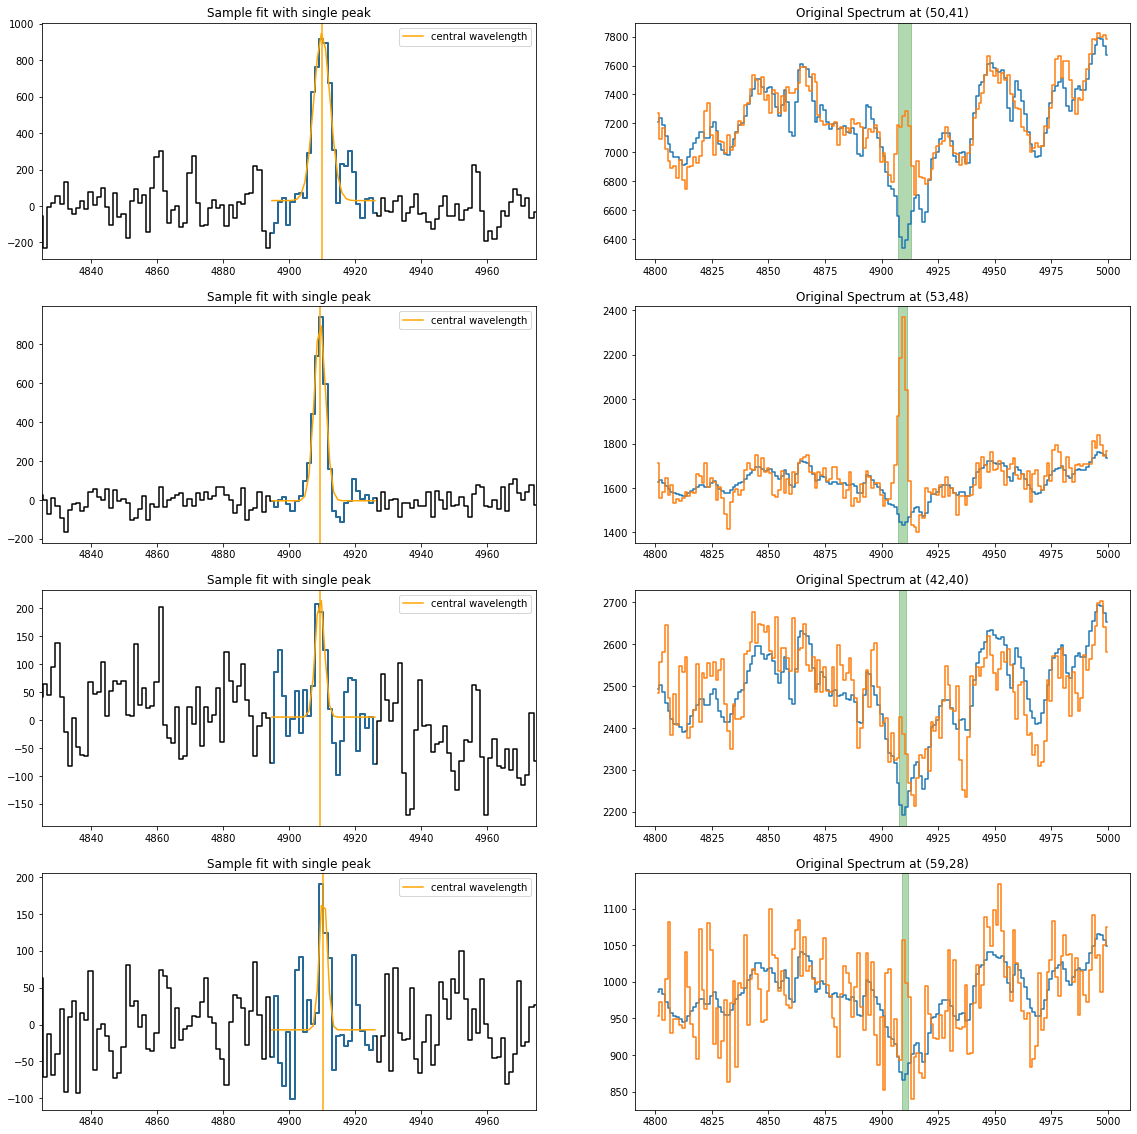

In [6]:
PIXELS = [(50,41), (53,48), (42,40), (59,28)]
hb.plot_eval(PIXELS)